In [1]:
# Final Project - Unsupervised Classification of Landsat 8 Imagery

In [ ]:
---
format: 
  html:
    toc: true
execute:
  echo: true
---

### Unsupervised classification 

Unsupervised classification is valuable in satellite imagery for its efficiency in data compression and anomaly detection, such as cloud and ship identification. It's also useful in semi-supervised learning, where it quickly categorizes unlabeled data, complementing partially labeled datasets.

For my analysis of satellite image classification, I first need to set up my coding environment. I'll start by importing all the necessary libraries. These include numpy for handling arrays, rasterio for input/output operations with remotely sensed data, scikit-learn for unsupervised classification and model evaluation, and matplotlib for data visualization. I also use the os library to manage file paths.

My focus was on obtaining satellite imagery of Kisumu. For this, I used OSMnx to download the data and ensured the data was in the correct format and projection (CRS) for accurate analysis.

In [26]:
#| echo: true 
#| code-fold: true
import os
import numpy as np
import rasterio as rio
from rasterio.mask import mask
from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from skimage.exposure import equalize_adapthist
import matplotlib.pyplot as plt

In [3]:
#| echo: true 
#| code-fold: true
#loading data
path = 'data/landsat8'
complete_dataset = os.listdir(path)
complete_dataset = [path + x for x in complete_dataset]
print(complete_dataset)

['data/landsat8.DS_Store', 'data/landsat8LC08_L1TP_170060_20230210_20230217_02_T1_B9.tif', 'data/landsat8LC08_L1TP_170060_20230210_20230217_02_T1_B8.tif', 'data/landsat8Icon\r', 'data/landsat8LC08_L1TP_170060_20230210_20230217_02_T1_B10.tif', 'data/landsat8LC08_L1TP_170060_20230210_20230217_02_T1_B11.tif', 'data/landsat8LC08_L1TP_170060_20230210_20230217_02_T1_B6.tif', 'data/landsat8LC08_L1TP_170060_20230210_20230217_02_T1_B7.tif', 'data/landsat8LC08_L1TP_170060_20230210_20230217_02_T1_B5.tif', 'data/landsat8LC08_L1TP_170060_20230210_20230217_02_T1_B4.tif', 'data/landsat8LC08_L1TP_170060_20230210_20230217_02_T1_B1.tif', 'data/landsat8LC08_L1TP_170060_20230210_20230217_02_T1_B3.tif', 'data/landsat8LC08_L1TP_170060_20230210_20230217_02_T1_B2.tif']


In [4]:
#| echo: true 
#| code-fold: true
path = 'data/landsat8'  
bands_list = [os.path.join(path, filename) for filename in os.listdir(path) if filename.endswith('.tif')]  

Before diving into the analysis, I started by visualizing the scene to understand its characteristics. For this, I use bands 2, 3, and 4 of the Landsat 8 scene. When applying the k-means algorithm, I incorporate a broader range of data, including bands 1 to 11. Since all these bands have a resolution of 30 meters per pixel, there's no need for upsampling or downsampling in the analysis.

In [5]:
#| echo: true 
#| code-fold: true
def show_rgb(bands_list, red=4, green=3, blue=2):
    stack = []
    for band_number in [red, green, blue]:
        # Adjust the pattern to match the filename structure we see in the output
        band_file = next((band for band in bands_list if f"T1_B{band_number}.tif" in band), None)
        if band_file:
            with rio.open(band_file) as src:
                array = src.read(1)
                # Normalize the array
                array = array.astype('float32')
                array_min, array_max = array.min(), array.max()
                array = (array - array_min) / (array_max - array_min)
                stack.append(array)
        else:
            print(f"No band file found for band number {band_number}")

    if stack:  # Check if stack is not empty
        stack = np.dstack(stack)
        # Display the image
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(stack)
        plt.show()
    else:
        print("No arrays were added to stack, check the band files.")

In [6]:
#| echo: true 
#| code-fold: true
# Example of using bands_list
band_number = 4  # Replace with the correct band number you are looking for
band_file = next((band for band in bands_list if f"T1_B{band_number}.tif" in band), None)


In [7]:
#| echo: true 
#| code-fold: true
band_file = next((band for band in bands_list if f"T1_B{band_number}.tif" in band), None)


['data/landsat8/LC08_L1TP_170060_20230210_20230217_02_T1_B9.tif', 'data/landsat8/LC08_L1TP_170060_20230210_20230217_02_T1_B8.tif', 'data/landsat8/LC08_L1TP_170060_20230210_20230217_02_T1_B10.tif', 'data/landsat8/LC08_L1TP_170060_20230210_20230217_02_T1_B11.tif', 'data/landsat8/LC08_L1TP_170060_20230210_20230217_02_T1_B6.tif', 'data/landsat8/LC08_L1TP_170060_20230210_20230217_02_T1_B7.tif', 'data/landsat8/LC08_L1TP_170060_20230210_20230217_02_T1_B5.tif', 'data/landsat8/LC08_L1TP_170060_20230210_20230217_02_T1_B4.tif', 'data/landsat8/LC08_L1TP_170060_20230210_20230217_02_T1_B1.tif', 'data/landsat8/LC08_L1TP_170060_20230210_20230217_02_T1_B3.tif', 'data/landsat8/LC08_L1TP_170060_20230210_20230217_02_T1_B2.tif']


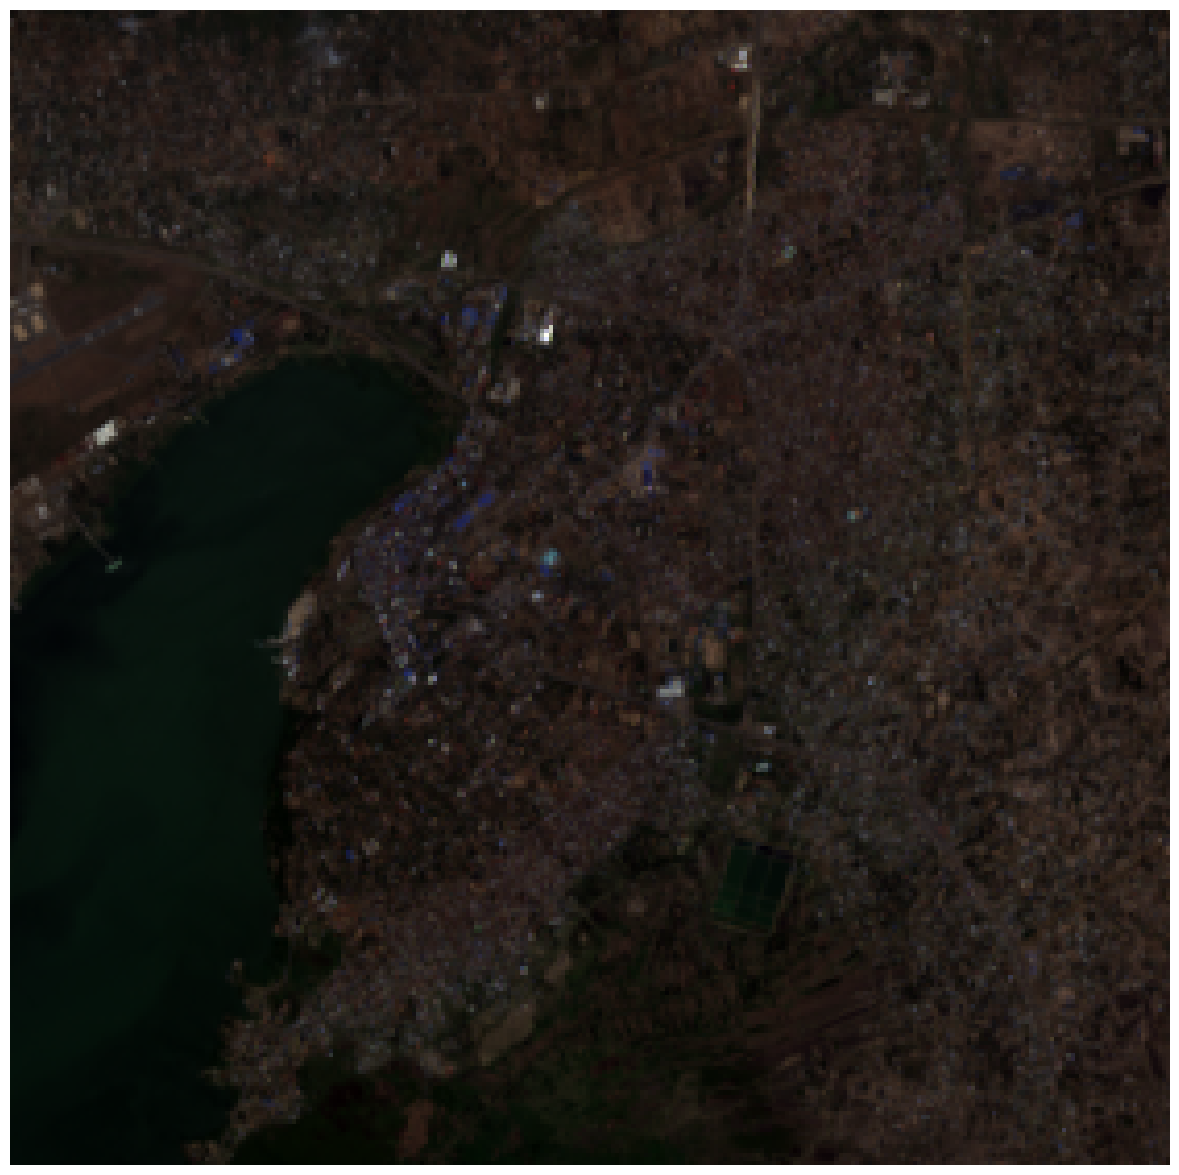

In [8]:
#| echo: false 
#| code-fold: true
path = 'data/landsat8'  # Adjust the path as needed
bands_list = [os.path.join(path, filename) for filename in os.listdir(path) if filename.endswith('.tif')]  # Make sure the extension matches
print(bands_list)  # Check the band paths
show_rgb(bands_list, red=4, green=3, blue=2)  # For natural color


### Bands display

The Kisumu area was densely packed with buildings and structures, making it challenging to discern vegetation or subtle details in the predominantly brownish images. To enhance visualization, particularly of man-made objects, I utilized a different band combination: 7-6-4. This selection significantly emphasizes these features. I adjusted the red, green, and blue arguments in the show_rgb function to accommodate this new combination.

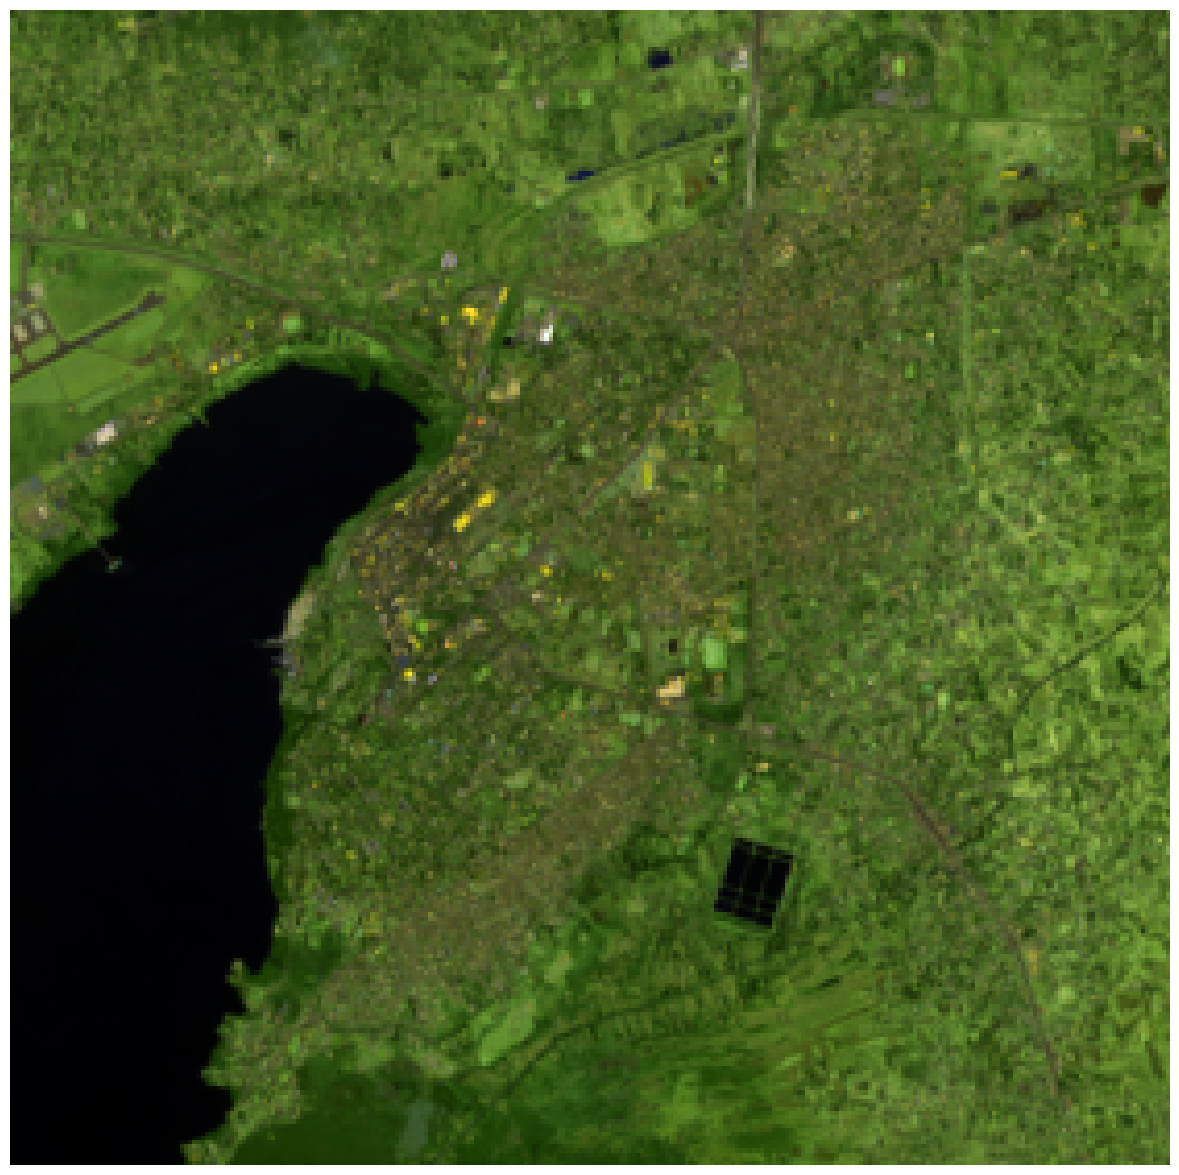

In [9]:
#| echo: false 
#| code-fold: true
show_rgb(bands_list, red=7, green=6, blue=4)

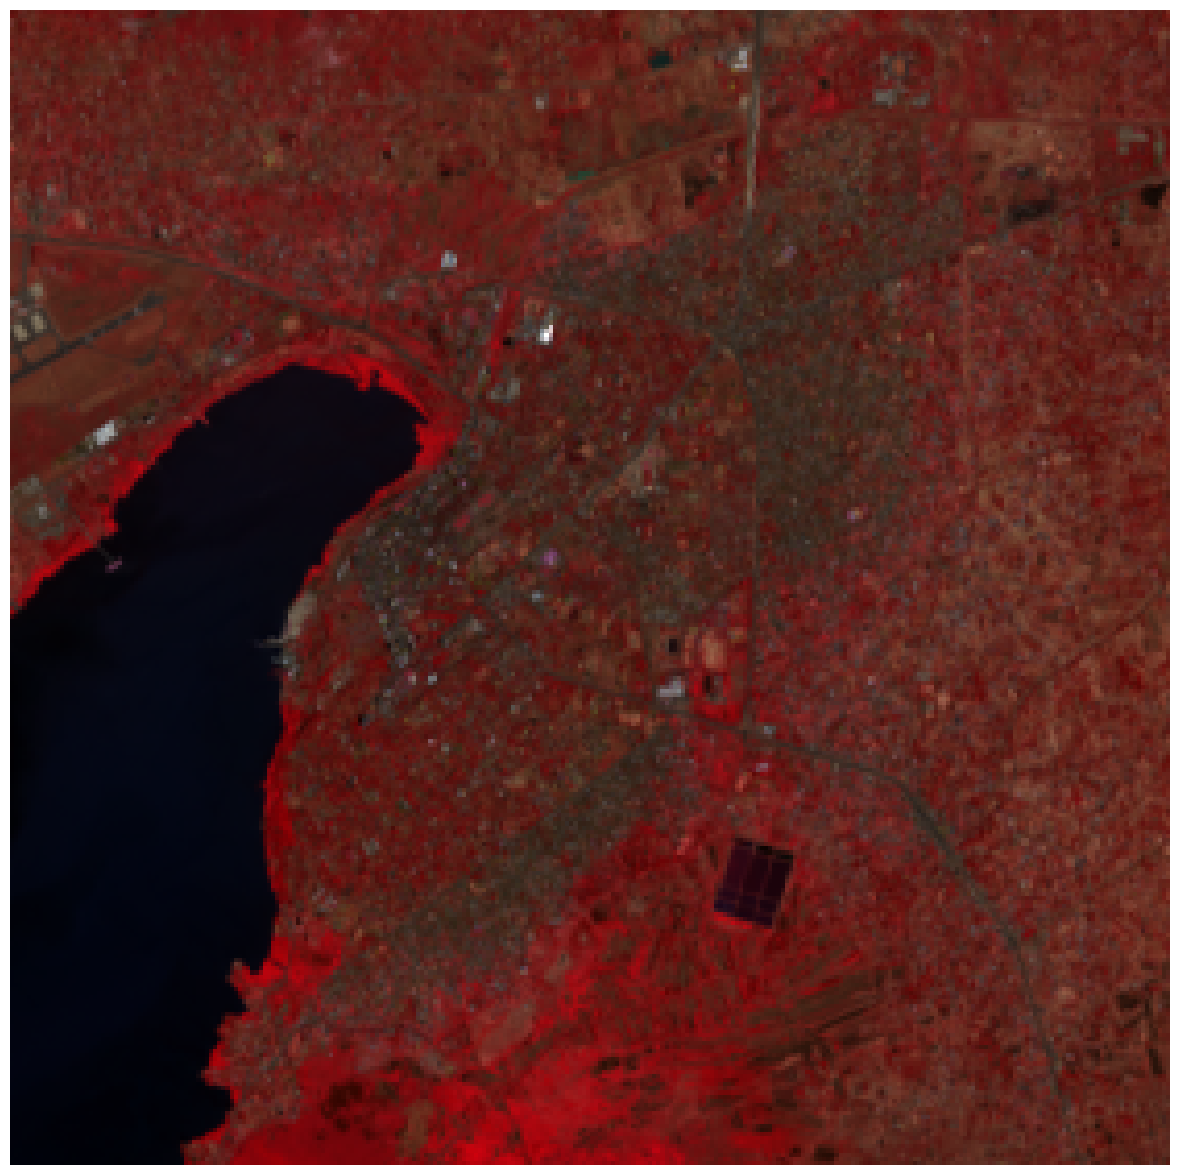

In [10]:
#| echo: true
#| code-fold: true
show_rgb(bands_list, red=5, green=4, blue=3)

For the models development, I employed the KMeans package to classify pixel values in the satellite images. I experimented with different numbers of clusters to understand which best captures the terrain types in the scene. To determine the number of clusters that best represent the terrain types, I experimented with 3 and 6 clusters, stacking all bands for a comprehensive analysis.

In [11]:
#| echo: true 
#| code-fold: true
# Stack all bands
def stack_bands(bands_list):
    stack = []
    for band_path in bands_list:
        with rio.open(band_path) as src:
            stack.append(src.read(1).flatten())  # Flatten each band
    return np.stack(stack, axis=1)

In [12]:
#| echo: true 
#| code-fold: true
for band_path in bands_list:
    with rio.open(band_path) as src:
        array = src.read(1)
        print(array.shape)  # Print out the shape of each array


(279, 280)
(558, 558)
(279, 280)
(279, 280)
(279, 280)
(279, 280)
(279, 280)
(279, 280)
(279, 280)
(279, 280)
(279, 280)


In [13]:
#| echo: true 
#| code-fold: true
def stack_bands(bands_list):
    stack = []
    for band_path in bands_list:
        with rio.open(band_path) as src:
            array = src.read(1)
            # Only append bands that match the desired shape (279, 280) for example
            if array.shape == (279, 280):
                stack.append(array.flatten())  # Flatten each band
            else:
                print(f"Excluded {band_path} due to shape mismatch: {array.shape}")
    return np.vstack(stack).T  # Use vstack and transpose to get the correct shape for KMeans

# Get the stacked data excluding any mismatched bands
data_stack = stack_bands(bands_list)


Excluded data/landsat8/LC08_L1TP_170060_20230210_20230217_02_T1_B8.tif due to shape mismatch: (558, 558)


In [14]:
#| echo: true 
#| code-fold: true
# Stack all bands
def stack_bands(bands_list):
    stack = []
    for band_path in bands_list:
        with rio.open(band_path) as src:
            stack.append(src.read(1).flatten())  # Flatten each band
    return np.stack(stack, axis=1)

In [15]:
#| echo: true 
#| code-fold: true
# Reshape the data
data_stack = stack_bands(bands_list)

ValueError: all input arrays must have the same shape

In [16]:
#| echo: true 
#| code-fold: true
# Standardize the data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data_stack)


In [17]:
#| echo: true 
#| code-fold: true
# Determine the optimal number of clusters
# Use methods like the Elbow method or Silhouette score here

# Sample for silhouette score
range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data_standardized)
    silhouette_avg.append(silhouette_score(data_standardized, cluster_labels))

/Users/kamya14o2/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kamya14o2/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kamya14o2/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kamya14o2/mambaforge/envs/musa-550-fall-2023/lib/pytho

In [18]:
#| echo: true 
#| code-fold: true
# Choose the optimal number of clusters
optimal_clusters = range_n_clusters[silhouette_avg.index(max(silhouette_avg))]


In [19]:
#| echo: true 
#| code-fold: true
# Apply K-Means Clustering
kmeans6 = KMeans(n_clusters=6, random_state=42)
y_pred = kmeans.fit_predict(data_standardized)

/Users/kamya14o2/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [20]:
#| echo: true 
#| code-fold: true
# Reshape classified data back to the original image shape
with rio.open(bands_list[0]) as src:
    meta = src.meta
    original_shape = (src.height, src.width)
classified_image6 = y_pred.reshape(original_shape)

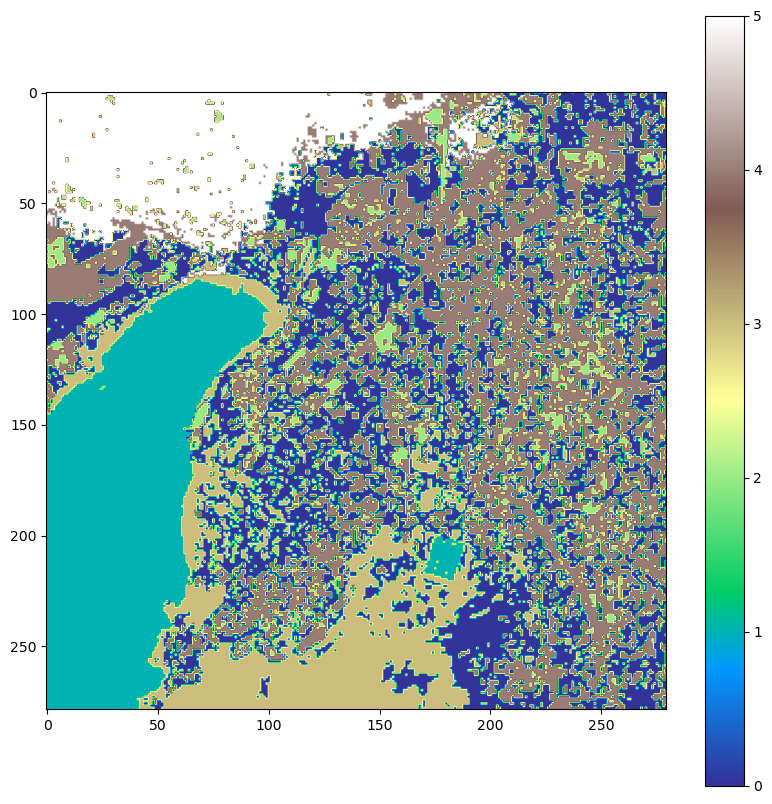

In [21]:
#| echo: false 
#| code-fold: true
# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(classified_image6, cmap='terrain')
plt.colorbar()
plt.show()

In [22]:
#| echo: false 
#| code-fold: true
# Assuming y_pred is your flattened array of predictions from KMeans
# and classified_image is your 2D array of cluster labels reshaped into the image's dimensions

# Count the occurrences of each cluster label
unique, counts = np.unique(classified_image6, return_counts=True)
cluster_counts6 = dict(zip(unique, counts))

# Calculate the total number of pixels
total_pixels6 = classified_image6.size

# Calculate the percentage of each cluster
cluster_percentages6 = {k: (v / total_pixels6) * 100 for k, v in cluster_counts6.items()}

# Print the percentages
for cluster, percentage in cluster_percentages6.items():
    print(f'Cluster {cluster}: {percentage:.2f}%')

Cluster 0: 29.80%
Cluster 1: 14.53%
Cluster 2: 4.30%
Cluster 3: 11.55%
Cluster 4: 28.88%
Cluster 5: 10.93%


/Users/kamya14o2/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


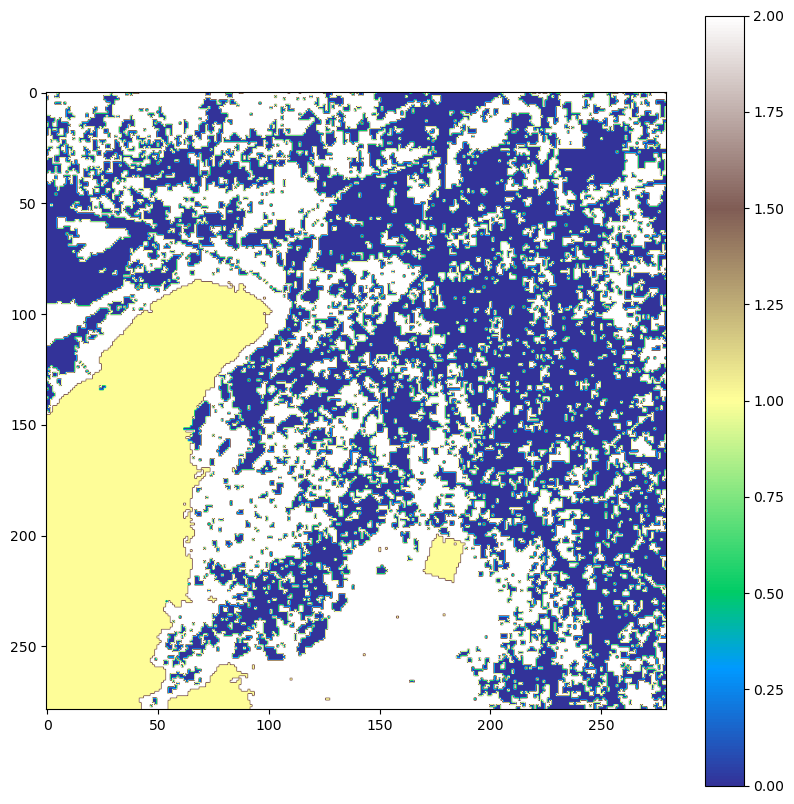

In [29]:
#| echo: true 
#| code-fold: true
# Apply K-Means Clustering
kmeans3 = KMeans(n_clusters=3, random_state=42)
y_pred = kmeans3.fit_predict(data_standardized)

# Reshape classified data back to the original image shape
with rio.open(bands_list[0]) as src:
    meta = src.meta
    original_shape = (src.height, src.width)
classified_image3 = y_pred.reshape(original_shape)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(classified_image3, cmap='terrain')
plt.colorbar()
plt.show()

In [24]:
#| echo: false 
#| code-fold: true
# Assuming y_pred is your flattened array of predictions from KMeans
# and classified_image is your 2D array of cluster labels reshaped into the image's dimensions

# Count the occurrences of each cluster label
unique, counts = np.unique(classified_image3, return_counts=True)
cluster_counts3 = dict(zip(unique, counts))

# Calculate the total number of pixels
total_pixels3 = classified_image3.size

# Calculate the percentage of each cluster
cluster_percentages3 = {k: (v / total_pixels3) * 100 for k, v in cluster_counts3.items()}

# Print the percentages
for cluster, percentage in cluster_percentages3.items():
    print(f'Cluster {cluster}: {percentage:.2f}%')

Cluster 0: 42.46%
Cluster 1: 15.46%
Cluster 2: 42.09%


In [ ]:
clustered_models = ClusteredBands(complete_dataset)
clustered_models.set_raster_stack()

After comparing the resulting images with the original RGB scene, I conclude that six categories yield the most optimal results. Three categories fail to capture the spatial variability, with a significant presence of NaN values obscuring useful data.